## 1. **Creating our circuits (for $l=0,...,4$)**

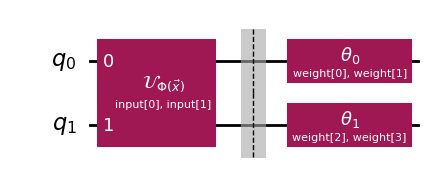

In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from gates import feature_gate, local_rot_gate

# Our circuits have the same input space
n_qubits = 2
n_dims = n_qubits
inputs = ParameterVector('input', n_dims)
min_layers = 0
max_layers = 4
qcs = []

for n_layers in range(min_layers, max_layers+1):
    weights = ParameterVector('weight', 2*n_qubits*(n_layers+1))

    # Feature map
    qc = QuantumCircuit(n_qubits)
    qc.append(feature_gate(inputs[0], inputs[1]), range(n_qubits))
    qc.barrier()

    # Parametric layer
    for i in range(n_qubits):
        qc.append(local_rot_gate(weights[2*i], weights[2*i+1], label=r'$\theta_'+str(i)+'$'), [i])

    for l in range(n_layers):
        qc.barrier()
        qc.cz(0, 1)
        for i in range(n_qubits):
            qc.append(local_rot_gate(weights[2*(n_qubits*(l+1)+i)], weights[2*(n_qubits*(l+1)+i)+1], 
            label=r'$\theta_'+str(i)+r'^'+str(l+1)+r'$'), [i])
    qcs.append(qc)

qcs[0].draw(output='mpl')

## 2. **Setting our Neural Networks**
For that, we'll use `qiskit_machine_learning`'s `SamplerQNN` that will output the empirical probabilities of the two classes given a parity function (here $f = Z_1Z_2$) and weights that we'll optimize.
We'll work with a binary classifier, the class index $0$ corresponds to the class $+1$ and the class index $1$ to the class $-1$.

In [ ]:
from qnn import AerQNN

# We create our NNs (training and evaluation)
num_shots_train = 2000
num_shots_eval = 10000
noise_rate = 0.8
train_qnns = []
test_qnns = []
for qc in qcs:
    qnn = AerQNN(qc, n_dims, n_shots=num_shots_train, noise_rate=noise_rate)
    train_qnns.append(qnn)
    qnn = AerQNN(qc, n_dims, n_shots=num_shots_eval, noise_rate=noise_rate)
    test_qnns.append(qnn)

### 2.1 **Setting our datasets**

In [3]:
# Load a our labeled datasets
from utility import load_list
training_dataset = load_list('datasets/train_dataset-2.json')
testing_dataset = load_list('datasets/eval_dataset-2.json')
training_dataset[:3]

[{'input': [1.7659725457302826, 0.6303145937419159], 'label': -1.0},
 {'input': [5.803656345258584, 1.3326750203869937], 'label': -1.0},
 {'input': [0.35463260954782977, 5.454558999145612], 'label': 1.0}]

## 3. **Training our QNNs**

### 3.1 **Using Empirical Risk $R_{emp}$**
Before the training, we need to define what error metric to use and the objective function we want to minimize. The error metric with simply be the sum of the probabilities to label wrong, i.e.
$$
R_{emp}(\vec\theta, b)=\frac{1}{|T|}\sum_{\vec x \in T}Pr(\tilde m(\vec x) \neq m(\vec x)) \approx
\frac{1}{|T|}\sum_{\vec x \in T}
\text{sig}\left(
\frac{\sqrt R \left(\frac{1}{2}-\left(\hat p_y(\vec x)-\frac{yb}{2}\right)\right)}
{\sqrt{2(1-\hat p_y(\vec x))\hat p_y(\vec x)}}
\right)
$$
Where $b$ is a bias to be optimized and $y = m(\vec x)$.

In [ ]:
from qnn import training
import numpy as np

# Training using scipy.optimize's COBYLA
logs_list = []
for i, qnn in enumerate(train_qnns):
    print(f'==== CIRCUIT l={i} ==== ')
    logs = training(
        train_qnn=qnn,
        test_qnn=test_qnns[i],
        init_weights=((np.random.rand(qnn.n_weights)-0.5)*np.pi/2).tolist(),
        init_bias=0,
        training_dataset=training_dataset,
        testing_dataset=testing_dataset,
        n_iter=200,
        fun='emp_risk'
    )
    logs_list.append(logs)

In [5]:
from utility import save_list
# We can save the weights and logs
save_list(logs_list, f'records/no-zne.json')

### 3.2 **Combining $R_{emp}$ with ZNE**

In [ ]:
from qnn import training
import numpy as np

# Training using scipy.optimize's COBYLA
logs_list = []
for i, qnn in enumerate(train_qnns):
    print(f'==== CIRCUIT l={i} ==== ')
    logs = training(
        train_qnn=qnn,
        test_qnn=test_qnns[i],
        init_weights=((np.random.rand(qnn.n_weights)-0.5)*np.pi/2).tolist(),
        init_bias=0,
        training_dataset=training_dataset,
        testing_dataset=testing_dataset,
        n_iter=200,
        fun='emp_risk',
        zne=True
    )
    logs_list.append(logs)

In [12]:
from utility import save_list
# We can save the weights and logs
save_list(logs_list, f'records/zne.json')

## 4. **Forwarding example**
After training our models, we can use weights to predict label classfication! The provided ones are the ones obtained after training of 200 steps with ZNE, $R=10k$, $R_S=20k$ and a noise rate $p=0.4$.

In [31]:
# We choose our weights
from utility import load_list
record = load_list(f'records/dataset2-zne-p0.4-10k-20k.json')

In [49]:
# We choose the circuit we want (l=0,...,4) and our datapoint
l = 1
x = (np.pi, np.pi)

In [50]:
# Prediction time!
res = test_qnns[l].forward(x, record[l]['final_weights'])[0]
print(f'Probability of positive class: {res[0]}')
print(f'Probability of negative class: {res[1]}')

Probability of positive class: 0.4758
Probability of negative class: 0.5242
